#### Example running SpaFHy with jupyter notebook for Pallas catchment(s)

In [1]:
import os
os.chdir(r'/Users/jpnousu/SpaFHy_v2.0')
from model_driver import parallel_driver
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

###############################################################################
# example parameters to run single catchment or multiple catchments in parallel
catchment = 'krycklan' # 'krycklan' / 'pallas' / 'hyytiala'
run_multiple = False # run multiple catchments in parallel (Boolean)
run_one = 12 # run one specific subcatchment (if pallas, 2 = lonmpolonjängänoja)
###############################################################################

# setting up subcatchments in catchment_no
if run_multiple: # running multiple catchments as in catchment_no
    if catchment == 'pallas':
        catchment_no = np.arange(2,13,1)
    elif catchment == 'krycklan':
        catchment_no = np.arange(1,23,1)
        exclude = [11, 17, 18, 19]
        catchment_no = np.setdiff1d(catchment_no, exclude)
else:
    catchment_no = run_one

folder = f'/Users/jpnousu/SpaFHy_RUNS/{catchment}' # output directory where the /results directory is located
outputfile = parallel_driver(catchment, catchment_no, create_ncf=True, create_spinup=False, output=True, folder=folder)

# Reading the .nc results file that was just created
results = xr.open_dataset(outputfile[0])

*** Catchment no.: 12 ***
*** Defined root soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used root soil IDs: {1.0, 3.0, 4.0, 5.0, 6.0, 8.0} ***
*** Defined organic soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used organic soil IDs: {1.0, 3.0, 4.0, 5.0, 6.0, 8.0} ***
*** Defined deep soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used soil IDs: {1.0, 3.0, 4.0, 5.0, 6.0, 8.0}
*** State variables assigned from parameters.py ***
*** Simulation forced with: /Users/jpnousu/SpaFHy_RUNS/krycklan/forcing/FORCING.csv
*** Running model ***
*** 2D run
*** Bucket organic layer drains according to Campbell 1985
Running timestep:  1
Timestep: 1 , iterations: 6 , conv1: 1.9895196601282805e-11 , H[max_index]: -5.821472167968523
Running timestep:  2
Timestep: 2 , iterations: 2 , conv1: 0.0003506065290252991 , H[max_index]: -3.3643476456807093
Running timestep:  3
Timestep: 3 , iterations: 2 , conv1: 0.00013416135934107842 , H[max_index]: -3.4003137865064446
Running timestep:  4
Timestep: 4 , iterations:

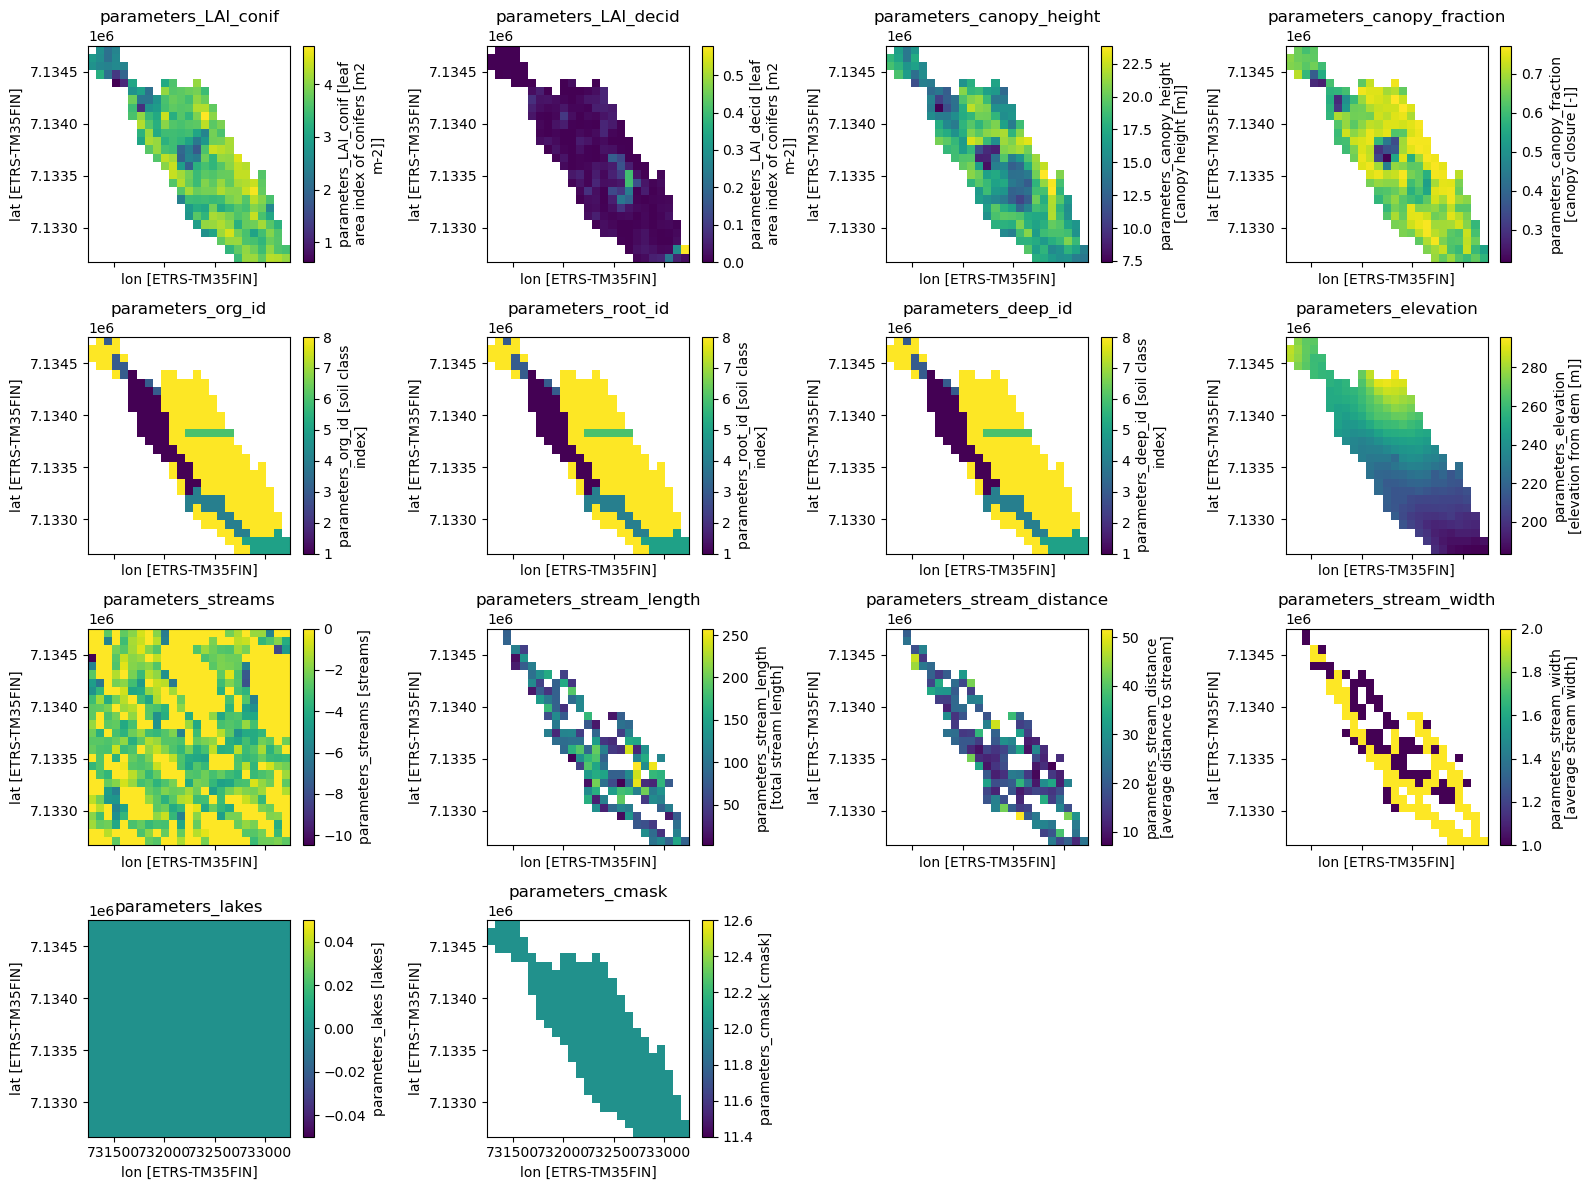

In [2]:
import math

# Collect all keys starting with "parameters_"
param_keys = [k for k in results.keys() if k.startswith("parameters_")]

# Grid setup: 4 columns, rows computed automatically
ncols = 4
nrows = math.ceil(len(param_keys) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)

axes = axes.flatten()

for ax, key in zip(axes, param_keys):
    results[key].plot(ax=ax)
    ax.set_title(key)

for ax in axes[len(param_keys):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


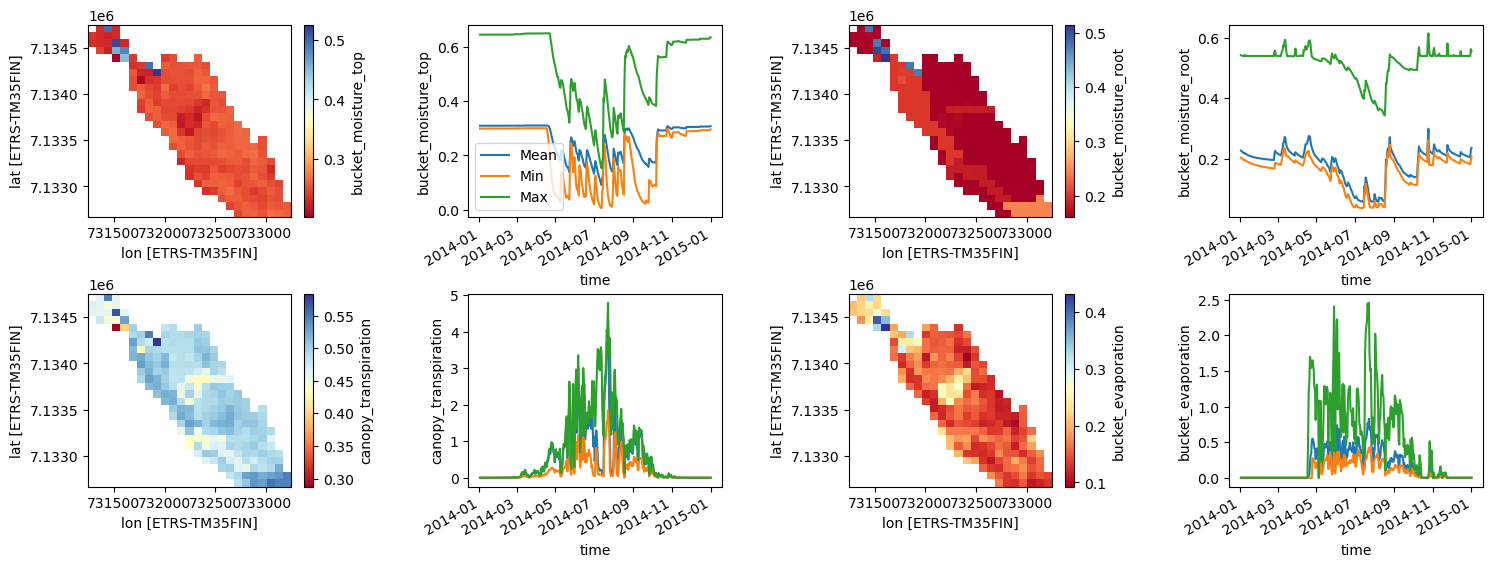

In [3]:
# example plot 1 (works for 1D, TOP, or 2D simulation)

fig, axes = plt.subplots(2, 4, figsize=(18, 6))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily index 0–7

# Plot 1
results['bucket_moisture_top'].mean(dim='time').plot(ax=axes[0], cmap='RdYlBu')

# Plot 2
results['bucket_moisture_top'].mean(dim=['lat', 'lon']).plot(ax=axes[1], label='Mean')
results['bucket_moisture_top'].min(dim=['lat', 'lon']).plot(ax=axes[1], label='Min')
results['bucket_moisture_top'].max(dim=['lat', 'lon']).plot(ax=axes[1], label='Max')
axes[1].legend()
# Plot 3
results['bucket_moisture_root'].mean(dim='time').plot(ax=axes[2], cmap='RdYlBu')

# Plot 4
results['bucket_moisture_root'].mean(dim=['lat', 'lon']).plot(ax=axes[3], label='Mean')
results['bucket_moisture_root'].min(dim=['lat', 'lon']).plot(ax=axes[3], label='Min')
results['bucket_moisture_root'].max(dim=['lat', 'lon']).plot(ax=axes[3], label='Max')

# Plot 5
results['canopy_transpiration'].mean(dim='time').plot(ax=axes[4], cmap='RdYlBu')

# Plot 6
results['canopy_transpiration'].mean(dim=['lat', 'lon']).plot(ax=axes[5], label='Mean')
results['canopy_transpiration'].min(dim=['lat', 'lon']).plot(ax=axes[5], label='Min')
results['canopy_transpiration'].max(dim=['lat', 'lon']).plot(ax=axes[5], label='Max')

# Plot 7
results['bucket_evaporation'].mean(dim='time').plot(ax=axes[6], cmap='RdYlBu')

# Plot 8
results['bucket_evaporation'].mean(dim=['lat', 'lon']).plot(ax=axes[7], label='Mean')
results['bucket_evaporation'].min(dim=['lat', 'lon']).plot(ax=axes[7], label='Min')
results['bucket_evaporation'].max(dim=['lat', 'lon']).plot(ax=axes[7], label='Max')

# Plot 8
#results['parameters_streams'].plot(ax=axes[7])

plt.subplots_adjust(wspace=0.5, hspace=0.4)  # Adjust spacing between plots

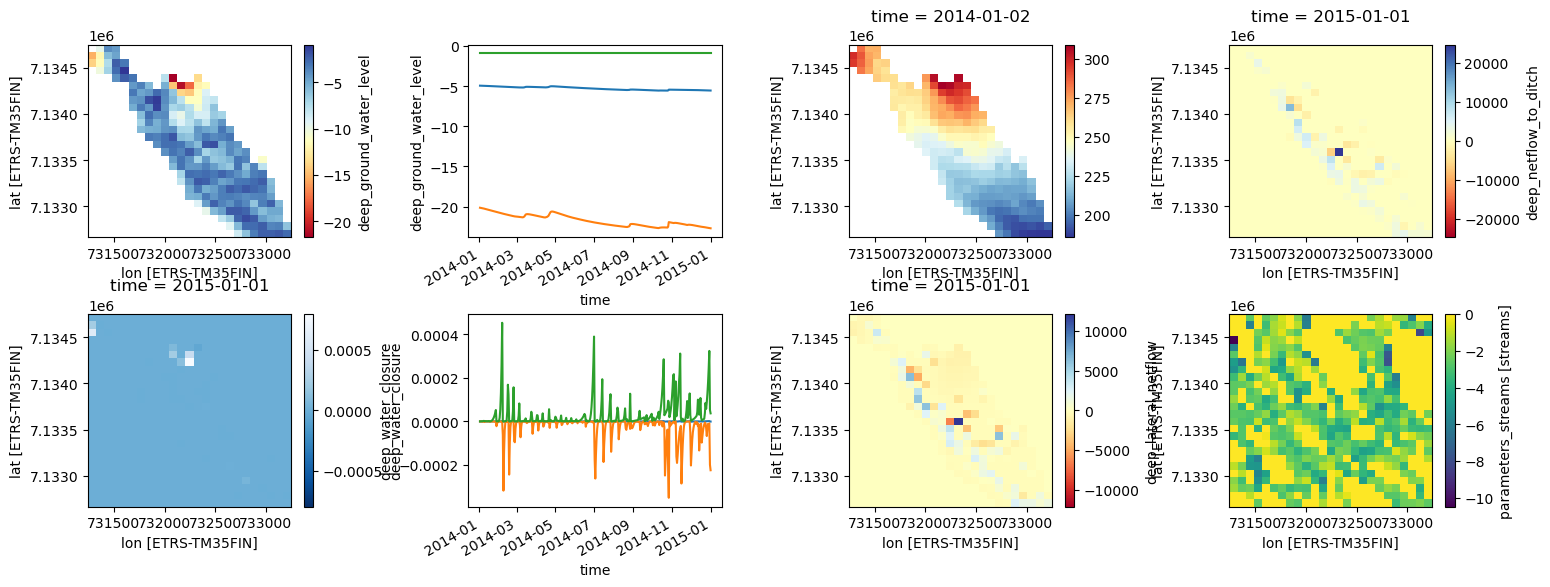

In [4]:
# example plot 2 (works only for 2D simulation)

fig, axes = plt.subplots(2, 4, figsize=(18, 6))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily index 0–7

# Plot 1
results['deep_ground_water_level'].mean(dim='time').plot(ax=axes[0], cmap='RdYlBu')

# Plot 3
results['deep_ground_water_level'].mean(dim=['lat', 'lon']).plot(ax=axes[1], label='Mean')
results['deep_ground_water_level'].min(dim=['lat', 'lon']).plot(ax=axes[1], label='Min')
results['deep_ground_water_level'].max(dim=['lat', 'lon']).plot(ax=axes[1], label='Max')

# Plot 2
(results['parameters_elevation'] - results['deep_ground_water_level'][0]).plot(ax=axes[2], cmap='RdYlBu_r')

# Plot 4
#results['deep_netflow_to_ditch'][0].plot(ax=axes[3])
results['deep_netflow_to_ditch'].cumsum(dim='time')[-1].plot(ax=axes[3], cmap='RdYlBu')

# Plot 5
#results['deep_water_closure'][-1].plot(ax=axes[4])
results['deep_water_closure'].cumsum(dim='time')[-1].plot(ax=axes[4], cmap='Blues_r')

# Plot 6
results['deep_water_closure'].mean(dim=['lat', 'lon']).plot(ax=axes[5], label='Mean')
results['deep_water_closure'].min(dim=['lat', 'lon']).plot(ax=axes[5], label='Min')
results['deep_water_closure'].max(dim=['lat', 'lon']).plot(ax=axes[5], label='Max')

# Plot 7
#results['deep_lateral_netflow'].min(dim='time').plot(ax=axes[6])
results['deep_lateral_netflow'].cumsum(dim='time')[-1].plot(ax=axes[6], cmap='RdYlBu')

# Plot 8
results['parameters_streams'].plot(ax=axes[7])

plt.subplots_adjust(wspace=0.5, hspace=0.4)  # Adjust spacing between plots